In [20]:
from typing import final

import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import torch.optim as optim
import CONSTANTS
from functions import *
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

warnings.filterwarnings('ignore')

In [21]:
COIN = 'BTC'
data = pd.read_csv(fullDataPath(COIN))
data

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,date,link,text,sentiment,score
0,2024-05-08,60851.04,63013.05,62315.75,61169.53,7486.425968,-1146.22,-1.839374,65890.2210,66417.9682,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
1,2024-05-09,60601.60,63424.14,61169.53,63073.57,8360.055382,1904.04,3.112726,66247.8435,66426.8854,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2,2024-05-10,60150.00,63470.00,63073.55,60787.47,11511.129910,-2286.08,-3.624467,66472.6375,66371.6810,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
3,2024-05-11,60450.13,61482.00,60787.99,60814.63,2338.068108,26.64,0.043824,66850.1930,66373.6450,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
4,2024-05-12,60576.05,61843.45,60814.64,61453.02,2694.975779,638.38,1.049714,67183.0820,66410.7176,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,2025-05-03,95765.13,96974.78,96929.81,95861.33,2077.556760,-1068.48,-1.102323,72647.6545,69787.8322,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
433,2025-05-04,94151.67,96312.51,95865.47,94272.55,2834.396865,-1592.92,-1.661620,71251.6105,69155.3058,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
434,2025-05-05,93500.01,95218.82,94272.54,94733.99,5180.158939,461.45,0.489485,69965.3730,68533.2834,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
435,2025-05-06,93363.28,96916.25,94733.99,96839.17,6163.867558,2105.18,2.222201,68693.1570,67843.8636,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0


clean up

In [45]:

data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])  # optional: drop rows where parsing failed
data['date'] = data['time'].dt.date

# 3.4) Coerce any non-numeric sentiment scores to NaN, then drop those rows:
data['score'] = pd.to_numeric(data['score'], errors='coerce')
data = data.dropna(subset=['score'])

# 3.5) Compute daily average sentiment and tweet count for each date:
daily_sent = (
    data
    .groupby('date')
    .agg(
        avg_sentiment=('score', 'mean'),
        tweet_count=('score', 'size')
    )
    .reset_index()
)

daily_sent.head()

,date,avg_sentiment,tweet_count
0,2024-05-08,0.0,1
1,2024-05-09,0.0,1
2,2024-05-10,0.0,1
3,2024-05-11,0.0,1
4,2024-05-12,0.0,1


In [46]:
price_df = data.copy()
price_df['date'] = pd.to_datetime(data['date'], errors='coerce')
price_df = price_df.dropna(subset=['date'])  # drop rows where parsing failed
price_df['date'] = price_df['date'].dt.date
price_df = price_df.set_index('date').sort_index()

In [47]:
# 5.1) Convert daily_sent to index='date', then join with price_df:
daily_sent = daily_sent.set_index('date').sort_index()

merged = price_df.join(daily_sent, how='inner')
# 'inner' means only dates present in BOTH price_df and daily_sent are kept.

# 5.2) If any days appear in price_df but lack sentiment, forward-fill or set zeros:
merged['avg_sentiment'] = merged['avg_sentiment'].fillna(method='ffill')
merged['tweet_count']    = merged['tweet_count'].fillna(0)

# 5.3) Drop any rows missing price (just in case):
merged = merged.dropna(subset=['close'])

merged.head()

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,link,text,sentiment,score,avg_sentiment,tweet_count
date,,,,,,,,,,,,,,,,,,,,,
2024-05-08,2024-05-08,60851.04,63013.05,62315.75,61169.53,7486.425968,-1146.22,-1.839374,65890.2210,66417.9682,...,0.0,0.0,0.0,-,-,-,-,0.0,0.0,1
2024-05-09,2024-05-09,60601.60,63424.14,61169.53,63073.57,8360.055382,1904.04,3.112726,66247.8435,66426.8854,...,0.0,0.0,0.0,-,-,-,-,0.0,0.0,1
2024-05-10,2024-05-10,60150.00,63470.00,63073.55,60787.47,11511.129910,-2286.08,-3.624467,66472.6375,66371.6810,...,0.0,0.0,0.0,-,-,-,-,0.0,0.0,1
2024-05-11,2024-05-11,60450.13,61482.00,60787.99,60814.63,2338.068108,26.64,0.043824,66850.1930,66373.6450,...,0.0,0.0,0.0,-,-,-,-,0.0,0.0,1
2024-05-12,2024-05-12,60576.05,61843.45,60814.64,61453.02,2694.975779,638.38,1.049714,67183.0820,66410.7176,...,0.0,0.0,0.0,-,-,-,-,0.0,0.0,1


In [48]:
def make_lag_features(df, col, lags=[1, 2, 3, 7, 14]):
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def make_rolling_features(df, col, windows=[3, 7, 14]):
    for w in windows:
        df[f'{col}_roll_mean_{w}'] = df[col].rolling(w).mean()
        df[f'{col}_roll_std_{w}']  = df[col].rolling(w).std()
    return df

# 6.1) Copy merged so we don’t overwrite
df_feats = merged.copy()

# 6.2) Create lag/rolling for “price”
df_feats = make_lag_features(df_feats, 'price', lags=[1,2,3,7,14])
df_feats = make_rolling_features(df_feats, 'price', windows=[3,7,14])

# 6.3) Create lag/rolling for “avg_sentiment”
df_feats = make_lag_features(df_feats, 'avg_sentiment', lags=[1,2,3,7])
df_feats = make_rolling_features(df_feats, 'avg_sentiment', windows=[3,7])

# 6.4) (Optional) Lag/rolling for “tweet_count”
df_feats = make_lag_features(df_feats, 'tweet_count', lags=[1, 2, 3, 7])
df_feats = make_rolling_features(df_feats, 'tweet_count', windows=[3, 7])

# 6.5) Drop any rows with NaNs generated by shifting/rolling
df_feats = df_feats.dropna().copy()

# 6.6) Create the “next‐day price” target: shift price by –1
df_feats['target_price'] = df_feats['price'].shift(-1)
df_feats = df_feats.dropna(subset=['target_price']).copy()

# 6.7) Define feature matrix X and label y
feature_cols = [c for c in df_feats.columns if c not in ['price', 'target_price']]
X = df_feats[feature_cols]
y = df_feats['target_price']

print("X shape:", X.shape)
print("y shape:", y.shape)

KeyError: 'price'

In [25]:
# 7.1) Split 80% train / 20% test (chronologically):
total = len(df_feats)
test_size = max(int(total * 0.2), 1)
train_size = total - test_size

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Train rows: {X_train.shape[0]}, Test rows: {X_test.shape[0]}")

# 7.2) Build a pipeline: StandardScaler + XGBoost
def build_model_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist',
            random_state=42
        ))
    ])

pipe = build_model_pipeline()

# 7.3) Hyperparameter distributions for RandomizedSearchCV
param_dist = {
    'model__n_estimators':    [50, 100, 200, 400],
    'model__max_depth':       [3, 5, 7, 9],
    'model__learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'model__subsample':       [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
}

tscv = TimeSeriesSplit(n_splits=5)  # 5-fold time-series CV

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 7.4) Fit on the training data only
search.fit(X_train, y_train)

print("Best CV RMSE (train):", -search.best_score_)
print("Best hyperparameters:", search.best_params_)


Train rows: 338, Test rows: 84
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV RMSE (train): 7411.674458029251
Best hyperparameters: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 9, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.8}


Test RMSE (price) = 3220.19


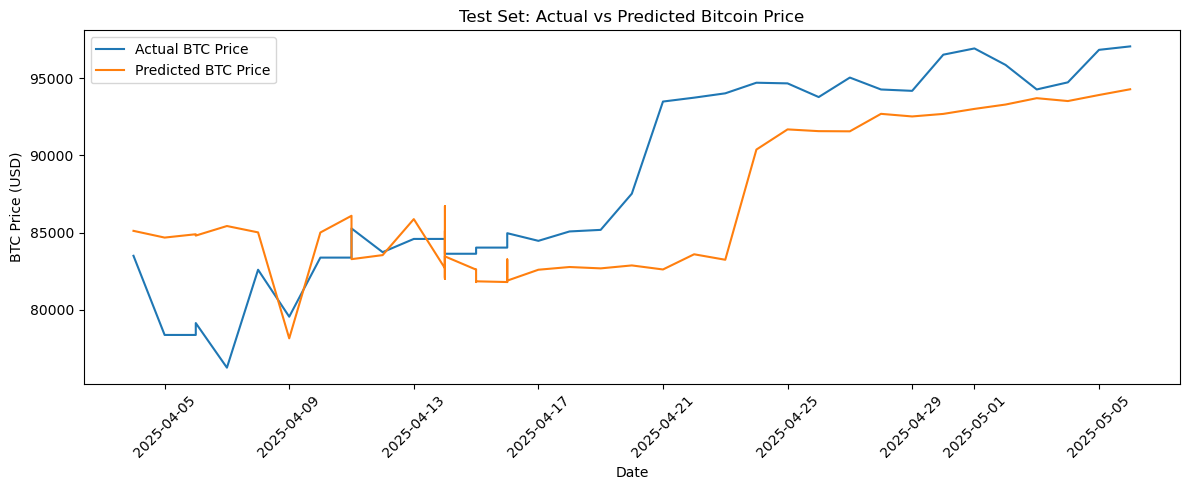

In [26]:
# 8.1) Predict on test using the best‐found model
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# 8.2) Compute test‐set RMSE on raw price
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE (price) = {test_rmse:.2f}")

# 8.3) Build a DataFrame for plotting
plot_df = pd.DataFrame({
    'actual_price':    y_test.values,
    'predicted_price': y_pred
}, index=df_feats.index[train_size:])  # these indices correspond to test period dates

# 8.4) Plot the result
plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df['actual_price'],    label='Actual BTC Price',    color='tab:blue')
plt.plot(plot_df.index, plot_df['predicted_price'], label='Predicted BTC Price', color='tab:orange')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('Test Set: Actual vs Predicted Bitcoin Price')
plt.legend()
plt.tight_layout()
plt.show()

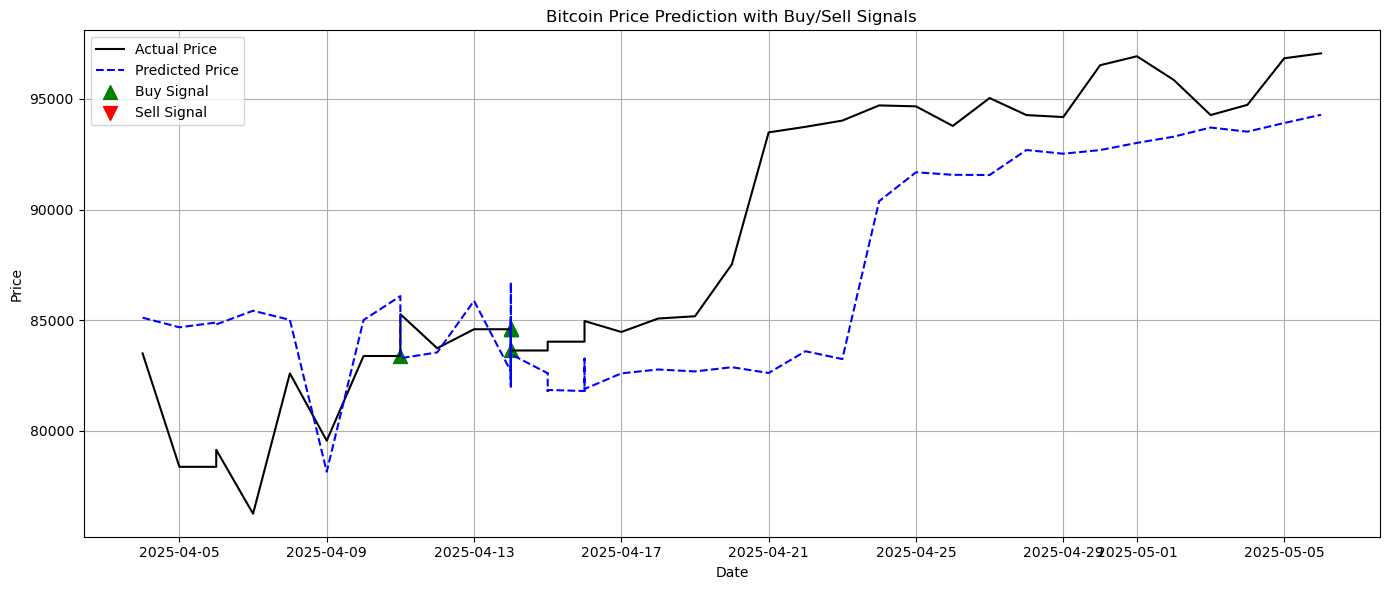

In [31]:
sentiment_buy_threshold = 0.3
sentiment_sell_threshold = -0.3
min_price_delta = 50

# Determine test period index using df_feats
signal_index = df_feats.index[train_size:]  # these are the dates in the test set

# Extract series aligned by position
actual_price = y_test.values
predicted_price = y_pred
sentiment = df_feats['avg_sentiment'].iloc[train_size:].values  # CHANGED to iloc

# Build DataFrame for signals
df_signals = pd.DataFrame({
    'actual_price':    actual_price,
    'predicted_price': predicted_price,
    'sentiment':       sentiment
}, index=signal_index)

# Compute price change of predictions
df_signals['price_change'] = df_signals['predicted_price'].diff().fillna(0)

# Buy if sentiment > threshold and expected price increase
df_signals['buy_signal'] = (
    (df_signals['sentiment'] > sentiment_buy_threshold) &
    (df_signals['price_change'] > min_price_delta)
)

# Sell if sentiment < threshold and expected price drop
df_signals['sell_signal'] = (
    (df_signals['sentiment'] < sentiment_sell_threshold) &
    (df_signals['price_change'] < -min_price_delta)
)

# Plot with buy/sell markers
plt.figure(figsize=(14,6))
plt.plot(df_signals.index, df_signals['actual_price'],    label='Actual Price',    color='black')
plt.plot(df_signals.index, df_signals['predicted_price'], label='Predicted Price', color='blue', linestyle='--')

plt.scatter(
    df_signals.index[df_signals['buy_signal']],
    df_signals['actual_price'][df_signals['buy_signal']],
    label='Buy Signal', color='green', marker='^', s=100
)
plt.scatter(
    df_signals.index[df_signals['sell_signal']],
    df_signals['actual_price'][df_signals['sell_signal']],
    label='Sell Signal', color='red', marker='v', s=100
)

plt.title('Bitcoin Price Prediction with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
